# Udacity Enron Fraud Detection Machine Learning Project

## Machine learning project using python 2.7 and sklearn to find out the best way to detect fraud from financial data and a set of emails taken from Enron employees. The below is the output of the program.

___

<p>The goal for this project is to try to predict who are persons of interest from how frequently 
someone corresponded via email with a known person of interest and by comparing various financial 
data points like the amound of the employee salary, bonus, total stock value, and stock options 
exercised. The machine learning library sklearn is used for predictions and to process the data 
and present visualizations using matplotlib. One major outlier in the data is that the total for all financial data points is included as a line in the data. This abviously makes it look like there was possibly one person who made enough money it couldn't possibly be legal. Once that record is removed a clearer picture starts to emerge. </p>



<p>Total number of data points:  146</p>
<p>Allocation across classes (POI/non-POI):  18 / 128</p>
<p>Number of features used:  21</p>
<p>Are there features with many missing values? etc. Yes, and here they are:</p>
<ul>
 <li>Number people with no salary data:  51</li>
 <li>Number NaN payments:  21</li>   
 <li>percent NaN payments:  0.143835616438</li>
 <li>Number of POIs no payments:  0</li>
 <li>percent poi NaN payments:  0.0</li>
</ul>

<p>The features I found that best aligned with more accurately predicting persons of interest were the financial points bonus and stock options exercised. I did explore whether or not an employee having a high percentage of email correspondence with a known person of interest correlated with them being a known person of interest, higher bonus or salary, or higher stock values. My hypothesis was that there would be a increased amount of cummunications among those who committed insider trading that correlated to them having a higher bonus or stock option value. There was a lot of noise on the scatter plot for this though and no clear regression pattern to follow, although most persons of interest did seem to fall around the 25% mark for communication with a POI. </p>

### import statements


In [2]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

#############################################################
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import linear_model

#from outlier_cleaner import outlierCleaner
from sklearn import model_selection
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from class_vis import prettyPicture

import copy
import pylab as pl

from time import time
from email_preprocess import preprocess

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

### Task 1: Select what features you'll use.
#### features_list is a list of strings, each of which is a feature name.
#### The first feature must be "poi".

In [3]:
features_list = ['poi','salary', 'deferral_payments', 'total_payments',
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income',
'total_stock_value', 'expenses', 'exercised_stock_options', 'other',
'long_term_incentive', 'restricted_stock', 'director_fees' ] 

email_features = ['to_messages', 'email_address', 'from_poi_to_this_person',
'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

POI_label = ['poi']


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


#total number of data points
num_data_points = len(data_dict)
print "\n - total number of data points: ", num_data_points

#allocation across classes (POI/non-POI)
poi_count = 0
for key in data_dict:
    if data_dict[key]['poi']==1:
        poi_count +=1
non_poi_count = 0
for key in data_dict:
    if data_dict[key]['poi']==0:
        non_poi_count +=1
print "\n - allocation across classes (POI/non-POI): ", poi_count,"/",non_poi_count

#number of features used
feature_count = 0
for key in range(len(data_dict[key])):
    feature_count += 1
print "\n - number of features used: ", feature_count

print "\n Are there features with many missing values? etc. Yes, and here they are"
no_salary = sum(1 for d in data_dict.values() if d['salary'] == 'NaN')
print "\n - Number people no salary: ", no_salary

no_payments = sum(1 for d in data_dict.values() if d['total_payments'] == 'NaN')
print "\n - Number NaN payments: ", no_payments

percent_no_payments = float(no_payments)/len(data_dict)
print "\n - percent NaN payments: ", percent_no_payments

poi_nan_payment_count = 0
poi_nan_payment = 0
for key in data_dict:
    if data_dict[key]['poi']==1:
        poi_nan_payment_count += 1
        if data_dict[key]['total_payments']=='NaN':
            poi_nan_payment += 1

print "\n - Number of POIs no payments: ", poi_nan_payment

percent_poi_nan_payment = float(poi_nan_payment)/poi_nan_payment_count
print "\n - percent poi NaN payments: ", percent_poi_nan_payment


#stuff nobody exactly asked for but here it is anyway
feature_sample = 0
for key in data_dict:
    print "\n - Sample person from dataset: ", key
    #print "\n - Number of features per person: ", len(data_dict[key])
    print "\n - Features: ", data_dict[key]

    feature_sample +=1
    if feature_sample == 1:
        break

df=pd.read_csv('poi_names.txt', header=None, skiprows=[0], sep=')')
df.columns = ['POI', "Name"]
df = df.replace(['\('], [''], regex=True)
#num_poi=df.count()
num_poi = df.POI.value_counts()
num_poi_we_have_emails = df.POI.value_counts()["y"]

print "\n - Total number of POIs: \n", num_poi
print "\n - Total number of POIs where we have their emails: ", num_poi_we_have_emails
print "\n",df.sort_values('POI', ascending=False)


 - total number of data points:  146

 - allocation across classes (POI/non-POI):  18 / 128

 - number of features used:  21

 Are there features with many missing values? etc. Yes, and here they are

 - Number people no salary:  51

 - Number NaN payments:  21

 - percent NaN payments:  0.143835616438

 - Number of POIs no payments:  0

 - percent poi NaN payments:  0.0

 - Sample person from dataset:  METTS MARK

 - Features:  {'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}

 - Total number of P

### Task 2: Remove outliers

In [4]:
data_dict.pop('TOTAL',0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)
data_dict.pop('LOCKHART EUGENE E',0)

print "New number of names in the dataset: ", len(data_dict), "\n"
for key in data_dict:
    print (key)
data = featureFormat(data_dict, features_list)

New number of names in the dataset:  143 

METTS MARK
BAXTER JOHN C
ELLIOTT STEVEN
CORDES WILLIAM R
HANNON KEVIN P
MORDAUNT KRISTINA M
MEYER ROCKFORD G
MCMAHON JEFFREY
HORTON STANLEY C
PIPER GREGORY F
HUMPHREY GENE E
UMANOFF ADAM S
BLACHMAN JEREMY M
SUNDE MARTIN
GIBBS DANA R
LOWRY CHARLES P
COLWELL WESLEY
MULLER MARK S
JACKSON CHARLENE R
WESTFAHL RICHARD K
WALTERS GARETH W
WALLS JR ROBERT H
KITCHEN LOUISE
CHAN RONNIE
BELFER ROBERT
SHANKMAN JEFFREY A
WODRASKA JOHN
BERGSIEKER RICHARD P
URQUHART JOHN A
BIBI PHILIPPE A
RIEKER PAULA H
WHALEY DAVID A
BECK SALLY W
HAUG DAVID L
ECHOLS JOHN B
MENDELSOHN JOHN
HICKERSON GARY J
CLINE KENNETH W
LEWIS RICHARD
HAYES ROBERT E
MCCARTY DANNY J
KOPPER MICHAEL J
LEFF DANIEL P
LAVORATO JOHN J
BERBERIAN DAVID
DETMERING TIMOTHY J
WAKEHAM JOHN
POWERS WILLIAM
GOLD JOSEPH
BANNANTINE JAMES M
DUNCAN JOHN H
SHAPIRO RICHARD S
SHERRIFF JOHN R
SHELBY REX
LEMAISTRE CHARLES
DEFFNER JOSEPH M
KISHKILL JOSEPH G
WHALLEY LAWRENCE G
MCCONNELL MICHAEL S
PIRO JIM
DELAINEY DAVI

### Task 3: Create new feature(s)
#### Store to my_dataset for easy export below.

In [5]:
my_dataset = data_dict

#### I'm trying to find a relation between percent of emails sent by each person to a poi and their stock values. Maybe something here?
#### I'm curious if people were asking about when to cash in stock options 

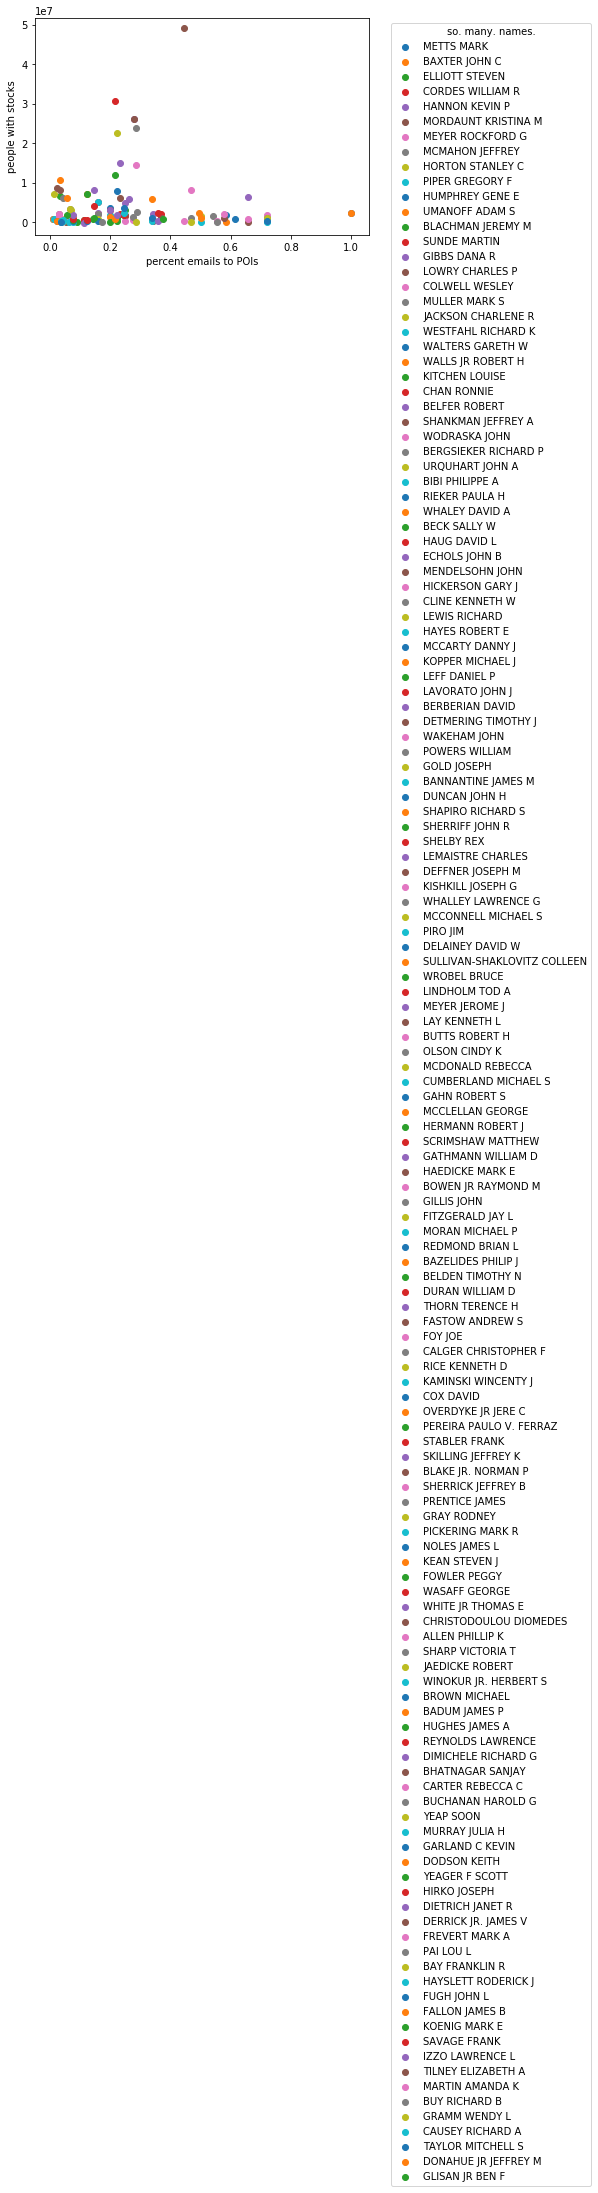

In [6]:
for point in my_dataset:
    to_poi = my_dataset[point]['from_this_person_to_poi']
    all_msgs_from_person = my_dataset[point]['from_messages']
    stonks = my_dataset[point]['total_stock_value']
    if to_poi != "NaN" and to_poi != 0 and all_msgs_from_person != "NaN" and all_msgs_from_person != 0:
        my_dataset[point]['percent_to_poi'] = float(to_poi)/float(all_msgs_from_person)
        percent_emails_to_poi = my_dataset[point]['percent_to_poi']
        #print "percent emails POI: ", point, percent_emails_to_poi
    if stonks != 0 and stonks != "NaN":
        people_with_stonks = stonks
        #print "people with stonks: ", point, people_with_stonks
    plt.scatter( percent_emails_to_poi, people_with_stonks )

plt.xlabel("percent emails to POIs")
plt.ylabel("people with stocks")
plt.legend(my_dataset.keys(), title='so. many. names.', bbox_to_anchor=(1.05, 1), loc='upper left' )
#plt.figure(figsize=(20,10)) 
#plt.show()



10% or more emails from POI:  UMANOFF ADAM S 0.108108108108
10% or more emails from POI:  COLWELL WESLEY 0.136518771331
10% or more emails from POI:  DEFFNER JOSEPH M 0.16106442577
10% or more emails from POI:  KISHKILL JOSEPH G 0.16106442577
10% or more emails from POI:  REDMOND BRIAN L 0.122082585278
10% or more emails from POI:  BAZELIDES PHILIP J 0.122082585278
10% or more emails from POI:  DURAN WILLIAM D 0.117256637168
10% or more emails from POI:  THORN TERENCE H 0.117256637168
10% or more emails from POI:  FASTOW ANDREW S 0.117256637168
10% or more emails from POI:  FOY JOE 0.117256637168
10% or more emails from POI:  DIETRICH JANET R 0.118584758942
10% or more emails from POI:  DONAHUE JR JEFFREY M 0.217341040462


Text(0,0.5,'bonus amount')

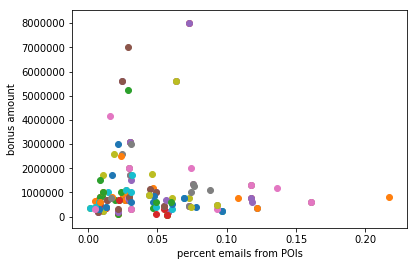

In [7]:
#more emails from poi means they liked a person and gave bigger bonus?
#filtered_data = {}
for point in my_dataset:
    from_poi = my_dataset[point]['from_poi_to_this_person']
    all_msgs_to_person = my_dataset[point]['to_messages']
    bonus = my_dataset[point]['bonus']
    if from_poi != "NaN" and from_poi != 0 and all_msgs_to_person != "NaN" and all_msgs_to_person != 0:
        my_dataset[point]['percent_from_poi'] = float(from_poi)/float(all_msgs_to_person)
        percent_emails_from_poi = my_dataset[point]['percent_from_poi']
    else:
        my_dataset[point]['percent_from_poi'] = 0
    if percent_emails_from_poi > 0.10:
        high_percent_from_poi = percent_emails_from_poi
        print "10% or more emails from POI: ", point, high_percent_from_poi
    if bonus != 0 and bonus != "NaN":
        people_with_bonus = bonus
        #print "people with bonus: ", point, people_with_bonus
    my_dataset[point]
    plt.scatter( percent_emails_from_poi, people_with_bonus )
    


plt.xlabel("percent emails from POIs")
plt.ylabel("bonus amount")
#legend has too many repeating colors to know what any of it means anyway so poof
#plt.legend(my_dataset.keys(), title='so many names', bbox_to_anchor=(1.05, 1), loc='upper left' )
#plt.figure(figsize=(20,10)) 
#plt.show()


### Task 4: Try a varity of classifiers
#### Please name your classifier clf for easy export below.
Note that if you want to do PCA or other multi-stage operations, you'll need to use Pipelines. For more info: http://scikit-learn.org/stable/modules/pipeline.html

Maybe. We'll see

In [8]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

from sklearn import tree, model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

features_train, features_test, labels_train, labels_test = model_selection.train_test_split(features, labels, test_size=0.3, random_state=2)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)

make_prediction = clf.predict(features_test)

In [9]:
score = accuracy_score(make_prediction, labels_test)
print "\n", "What is the accuracy score? ", score, "\n"

tree_poi_count = sum(labels_test)
print "How many POIs are predicted for the test set? ", tree_poi_count, "\n"

tree_set_count = len(labels_test)
print "How many people total are in your test set?", tree_set_count, "\n"

hypothetitree_accuracy = ((tree_set_count-poi_count)/tree_set_count)
print "If your identifier predicted 0. (not POI), what would its accuracy be?", hypothetitree_accuracy, "\n"

tree_true_positives = 0
for i in range(len(labels_test)):
    if labels_test[i] == 1 and make_prediction[i] == 1:
        tree_true_positives += 1

any_tree_positives = ["yes" if tree_true_positives > 0 else "no"]
print "Do you get any true positives? ", any_tree_positives, "\n"

tree_poi_precision = precision_score(make_prediction, labels_test)
print "poi precision: ", tree_poi_precision, "\n"

tree_poi_recall = recall_score(make_prediction, labels_test)
print "poi recall: ", tree_poi_recall, "\n"


What is the accuracy score?  0.813953488372093 

How many POIs are predicted for the test set?  8.0 

How many people total are in your test set? 43 

If your identifier predicted 0. (not POI), what would its accuracy be? 0 

Do you get any true positives?  ['yes'] 

poi precision:  0.5 

poi recall:  0.5 



<p>Validation let's you check the results of your features and adjust paramenters as needed to increase the scores</p>
<p>The measure precision is the proportion of true positive results predicted. It can be found by dividing the number or true positives byt the number of true positives plus the nubmer of false positives.</p>
<p>Recall is the proportion of true positives identified. the formula for recall is true_positives/(true_positives+false_negatives)</p>
<p>Accuracy is the number of correct predictions divided by the total number of predictions.</p>

In [10]:
def Draw(pred, features, poi, mark_poi=False, name="image.png", f1_name="feature 1", f2_name="feature 2"):
    """ some plotting code designed to help you visualize your clusters """

    ### plot each cluster with a different color--add more colors for
    ### drawing more than five clusters
    colors = ["b", "c", "k", "m", "g"]
    for ii, pp in enumerate(pred):
        plt.scatter(features[ii][0], features[ii][1], color = colors[pred[ii]])

    ### if you like, place red stars over points that are POIs (just for funsies)
    if mark_poi:
        for ii, pp in enumerate(pred):
            if poi[ii]:
                plt.scatter(features[ii][0], features[ii][1], color="r", marker="x")
    plt.xlabel(f1_name)
    plt.ylabel(f2_name)
    plt.savefig(name)
    #plt.legend(my_dataset.keys(), fontsize='xx-small', )
    plt.show()

In [11]:
exercised_options = []
for i in my_dataset:
    record = my_dataset[i]["total_stock_value"]
    if record != "NaN":
        exercised_options.append(record)

print "\n minimum stock options exercised: ", min(exercised_options)
print "\n maximum stock options exercised: ", max(exercised_options)

bonus_not_zero = []
for b in my_dataset:
    record = my_dataset[b]["bonus"]
    if record != "NaN":
        bonus_not_zero.append(record)

print "\n minimum bonus: ", min(bonus_not_zero)
print "\n max bonus: ", max(bonus_not_zero)


 minimum stock options exercised:  -44093

 maximum stock options exercised:  49110078

 minimum bonus:  70000

 max bonus:  8000000


In [12]:
for point in my_dataset:
    to_poi = my_dataset[point]['from_this_person_to_poi']
    all_msgs_from_person = my_dataset[point]['from_messages']
    if to_poi != "NaN" and to_poi != 0 and all_msgs_from_person != "NaN" and all_msgs_from_person != 0:
        my_dataset[point]['percent_to_poi'] = float(to_poi)/float(all_msgs_from_person)
        #percent_emails_to_poi = my_dataset[point]['percent_to_poi']
    else:
        my_dataset[point]['percent_to_poi'] = 0

<p>I used MinMaxScaler to adjust the scale for the financial features to be comparable to email frequency then plotted the data against bonus amounts and used kmeans clustering to show in different shades of blue the groups of possible POIs and non-POIs. This may have failed because we only have email data on four known persons of interest. Or I was just wrong. At any rate, my dreams of Robert Mueller and James Comey coming to me for advice on solving crimes is not a likely scenario. </p>

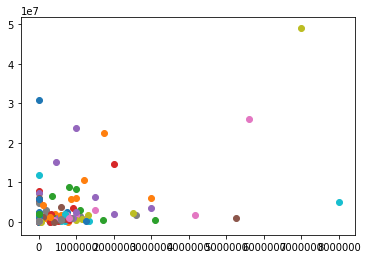

In [13]:
features_list = ['poi','salary', 'total_payments','loan_advances', 'bonus', 
'restricted_stock_deferred', 'deferred_income','total_stock_value', 
'exercised_stock_options', 'restricted_stock', "percent_to_poi", 'percent_from_poi'] 


### the input features in the person-level dictionary (salary, director_fees, etc.) 
feature_1 = "bonus"
feature_2 = "total_stock_value"
#feature_3 = "salary"
poi  = "poi"
features_list = [poi, feature_1, feature_2]
data = featureFormat(my_dataset, features_list )
poi, finance_features = targetFeatureSplit( data )


### if you add a feature you'll want to change this line to 
### for f1, f2, _ in finance_features:
### (as it's currently written, the line below assumes 2 features)
for f1, f2 in finance_features:
    plt.scatter( f1, f2 )
#plt.legend(my_dataset.keys(), fontsize='xx-small', )
plt.show()

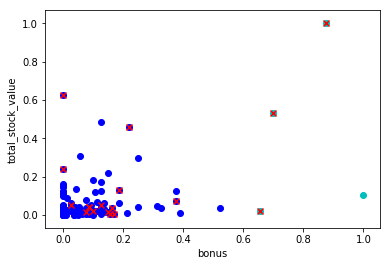

Rescaled $8,000,000 bonus and $1,000,000 exercised stock options:  [[0.00875    0.16365026]]


In [14]:
### cluster here; create predictions of the cluster labels
### for the data and store them to a list called pred

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rescaled_features = scaler.fit_transform(finance_features)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(rescaled_features)
pred = kmeans.predict(rescaled_features)

try:
    Draw(pred, rescaled_features, poi, mark_poi=True, name="scaled_clusters.pdf", f1_name=feature_1, f2_name=feature_2)
except NameError:
    print "no predictions object named pred found, no clusters to plot"

bonus_and_options = np.array([[70000., 8000000.]])
rescaled_bonus_options = scaler.transform(bonus_and_options)

print "Rescaled $8,000,000 bonus and $1,000,000 exercised stock options: ", rescaled_bonus_options


#### Here's what the clustering looks like trying to see if percent of emails to a poi means anything

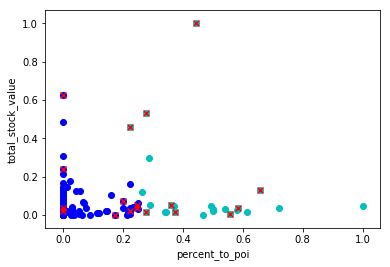

In [15]:
### the input features in the person-level dictionary (salary, director_fees, etc.) 
feature_1 = "percent_to_poi"
feature_2 = "total_stock_value"
#feature_3 = "salary"
poi  = "poi"
features_list = [poi, feature_1, feature_2]
data = featureFormat(my_dataset, features_list )
poi, finance_features = targetFeatureSplit( data )


scaler = MinMaxScaler()
rescaled_features = scaler.fit_transform(finance_features)

kmeans = KMeans(n_clusters=2, random_state=0).fit(rescaled_features)
pred = kmeans.predict(rescaled_features)

try:
    Draw(pred, rescaled_features, poi, mark_poi=True, name="scaled_clusters.pdf", f1_name=feature_1, f2_name=feature_2)
except NameError:
    print "no predictions object named pred found, no clusters to plot"

### ok wait what I thought this one wasn't doing anything but the plot just wasn't showing up? That does kinda look better. Yay jupyter! Maybe they didn't communicate telepathically after all. That looks like 9 true positives


<p>Up next is SVC.</p>

In [16]:


features_train, features_test, labels_train, labels_test = model_selection.train_test_split(features, labels, test_size=0.3, random_state=5)

clf = SVC(C=1000000.0, kernel="rbf", gamma="scale", random_state=5)
clf.fit( features_train, labels_train )
pred = clf.predict( features_test )

acc = accuracy_score(pred, labels_test)

print "\naccuracy: ", acc, "\n"

true_positives = 0
for i in range(len(labels_test)):
    if labels_test[i] == 1 and pred[i] == 1:
        true_positives += 1

print "how many true positives? ", true_positives, "\n"

poi_precision = precision_score(pred, labels_test)
print "poi precision: ", poi_precision, "\n"

poi_recall = recall_score(pred, labels_test)
print "poi recall: ", poi_recall, "\n"



accuracy:  0.813953488372093 

how many true positives?  3 

poi precision:  0.5 

poi recall:  0.375 



In [17]:
#GaussianNB 
select_k_best = SelectKBest(k=5)
SVC_clf = Pipeline(steps= [("minmax", scaler), ("k_best", select_k_best), ("SVC", SVC(C=1000000.0, kernel="rbf", gamma="scale", random_state=5))]) 
decision_tree_clf = Pipeline(steps= [("minmax", scaler), ("k_best", select_k_best), ("decision_tree", DecisionTreeClassifier())])
#kmeans_clf = Pipeline(steps= [("minmax", scaler), ("k_best", select_k_best), ("kmeans", KMeans())]) 
#so this was a bad idea. leave that commented
gaussian_clf = Pipeline(steps= [("minmax", scaler), ("k_best", select_k_best), ("gaussian", GaussianNB())])

classifier = [SVC_clf, decision_tree_clf, gaussian_clf]
for i in classifier:
    clf = i
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    
    print "clf:       ", clf
    print "accuracy:  ", accuracy_score(pred, labels_test)
    print "precision: ", precision_score(pred, labels_test)
    print "recall:    ", recall_score(pred, labels_test)

#clf = clf.fit(features_train, labels_train)
#gaussian_pred = GaussianNB(labels_test)

#print gaussian_pred

#print clf.predict(features_test)


clf:        Pipeline(memory=None,
     steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('k_best', SelectKBest(k=5, score_func=<function f_classif at 0x000000000C86D048>)), ('SVC', SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False))])
accuracy:   0.8372093023255814
precision:  0.5
recall:     0.42857142857142855
clf:        Pipeline(memory=None,
     steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('k_best', SelectKBest(k=5, score_func=<function f_classif at 0x000000000C86D048>)), ('decision_tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
   ...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
accuracy:   0.8372093023255814
precision:  0.5


#### Getting close, ok trying GridSearchCV

In [18]:
#parameters = ([{'kernel':['rbf', 'linear'], 'C':[100, 10000], 
#              'gamma':['auto', 'scale']}])

#SVC_clf = Pipeline(steps= [("minmax", scaler), ("k_best", select_k_best), ("SVC", SVC())])

#clf = GridSearchCV(estimator=SVC_clf, param_grid=parameters,refit=True,verbose=2)
#clf = clf.fit(features_train, labels_train)
#pred = clf.predict(features_test)

#print "accuracy:  ", accuracy_score(pred, labels_test), "\n"
#print "precision: ", precision_score(pred, labels_test), "\n"
#print "recall:    ", recall_score(pred, labels_test), "\n"
#print "best params", clf.best_estimator_
### some parallel n_jobs=1 sequential backend error - already manually tuned SVC


### Manually model tuning the SVC got it above the cut off and the decision tree was also good enough but putting them through the classifier raised the precision on the decision tree (at a slight cost to the recall though). It improved the SVC significantly and GaussianNB didn't even work without errors before the classifier. I would've guessed for years manually tuning and never even known half these parameters exist before choosing the optimal parameters. 

### I'm going with SVC for my final answer. 

In [19]:
new_scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
new_kbest = SelectKBest(k=5)
clf = Pipeline(steps= [("new_scaler", new_scaler), ("k_best", new_kbest), 
                           ("SVC", SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=4, shrinking=True,
  tol=0.001, verbose=False))]) 

clf = clf.fit( features_train, labels_train )
pred = clf.predict( features_test )

acc = accuracy_score(pred, labels_test)

print "\nSVC After Tuning \n\n"
print "Final accuracy: ", acc, "\n"

true_positives = 0
for i in range(len(labels_test)):
    if labels_test[i] == 1 and pred[i] == 1:
        true_positives += 1

print "True positives ", true_positives, "\n"

poi_precision = precision_score(pred, labels_test)
print "Final precision: ", poi_precision, "\n"

poi_recall = recall_score(pred, labels_test)
print "Final recall: ", poi_recall, "\n"


SVC After Tuning 


Final accuracy:  0.8372093023255814 

True positives  3 

Final precision:  0.5 

Final recall:  0.42857142857142855 



In [20]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)